# 确定扫描场景的几何参数———以2维扇形束为例

<span style="font-size: 20px; color: black;">这段代码演示了使用ASTRA工具箱进行计算机断层成像(CT)重建的基本流程，主要功能包括：</span>  
- <span style="font-size: 20px; color: black;">创建CT扫描的几何参数配置（扫描几何+重建体积几何）</span> 
- <span style="font-size: 20px; color: black;">生成Shepp-Logan仿体（测试图像）  </span>
- <span style="font-size: 20px; color: black;">通过GPU投影运算生成正弦图（sinogram）  </span>
- <span style="font-size: 20px; color: black;">可视化原始图像和投影数据  


# <span style="font-size: 30px; color: blue;">1. 导入工具包</span>
<span style="font-size: 20px; color: black;">python文件的第一步通常是引入所需要的包</span>

In [1]:
import astra
import numpy as np  #python主要的矩阵数据处理库
import pylab        #用于可视化

# <span style="font-size: 30px; color: blue;">2. 确定几何</span>
<span style="font-size: 20px; color: black;">我们需要根据实际场景确定工程的几何参数设置.以下面图片展示的场景为例子</span>

![image.png](CT_beam.png)

<span style="font-size: 20px; color: black;">与平行束CT扫描系统不同，在扇形束成像中,光源到成像中心的距离以及探测板中心到成像中心的距离也会影响成像</span>  

In [2]:
#体积参数
vol_geom = astra.create_vol_geom(256, 256)
#投影参数
proj_geom = astra.create_proj_geom(
    'fanflat', # 使用扇形束
    1.0, # 探测器间距1像素
    512,           # 有384个探测单元
    np.linspace(0, np.pi, 180, False),# 从0到180°拍180张（每1° 1张），False表示不包含终点
    512, #光源到成像中心的距离
    512  #探测板中心到成像中心
)
#创建投影器
proj_id = astra.create_projector('cuda', proj_geom, vol_geom) 
# 'cuda'表示使用NVIDIA显卡加速

# <span style="font-size: 30px; color: blue;">3. 生成测试图像</span>
<span style="font-size: 20px; color: black;">Shepp-Logan仿体是国际公认的CT测试模型：</span>

In [3]:
phantom_id, P = astra.data2d.shepp_logan(vol_geom) 
# phantom_id : 数据对象ID
# P : 实际的256×256像素图像数据

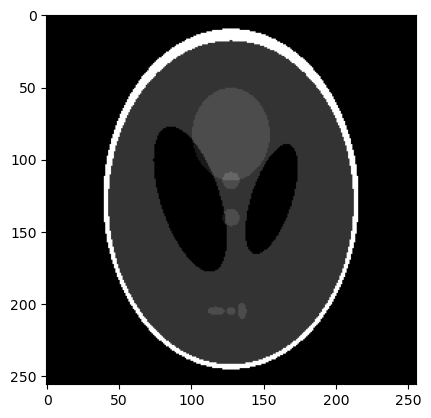

In [4]:
#可视化
pylab.gray()  # 使用灰度图显示
pylab.figure(1)
pylab.imshow(P) 

# <span style="font-size: 30px; color: blue;">4. 正投影模拟</span>
<span style="font-size: 20px; color: black;">接下来我们要计算这个几何条件下的正投影弦图。当扫描架以等角步进（Δθ=1°）旋转时，512个探测单元以1mm间距同步采集穿透仿体的衰减信号，最终形成180×512的投影矩阵</span>

In [5]:
sinogram_id, sinogram = astra.create_sino(P, proj_id)
# sinogram : 生成的180×512正弦图数据
sinogram.shape

(180, 512)

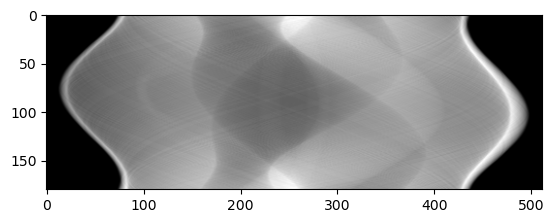

In [6]:
pylab.figure(2)
pylab.imshow(sinogram) # 显示CT扫描结果（像扇形展开的胶片）
pylab.show()

# <span style="font-size: 30px; color: blue;">5. 清理内存</span>
<span style="font-size: 20px; color: black;">ASTRA会在GPU上分配内存，需要手动释放</span>

In [7]:
astra.data2d.delete(sinogram_id) 
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)